In [1]:
# %%html
# <style>
#     #notebook-container{
#     width: 100%
#     }
# </style>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.optimize import minimize

sns.set()

# Problem 3
## Task (c)

In this task I will generate matrix $A$ of size $20 \times 10$ and vector $b$ of size $20 \times 1$. Next I will find solution $\hat x = A^+ b$ using pseudoinverse $A^+$ of matrix $A$, found by using built-in python function. Afterwards, I will implement Richardson iteration scheme in respective method and try to find solution with tolerance 0,001 for the same system $Ax=b$. To show that Richardson method will converge, I will plot norm of distance between $x_k$, calcualted on each step, and $\hat x$ with respect to number of iterations. Expectation  is that such norm should go to 0 with increase of number of iterations.

In [3]:
def richardson_step(x_old, A, b): #defining single step of Richardson iteration scheme
    return x_old - np.dot(A.T,(np.dot(A,x_old)-b))/(np.linalg.norm(A)**2) #calculating new value of x

def richardson_iter(x_old, A, b, acc, x_hat): #defining method for iteration scheme for Richardson
    iter_count = 0
    errors=[]
    
    while True: #implementing do-while loop
        iter_count += 1
        x_new = richardson_step(x_old, A, b) #calculating new value for x using single step method Richardson method
        errors.append(np.linalg.norm(x_new - x_hat)) #calculating errors and saving to list
        if np.linalg.norm(np.dot(A.T,(np.dot(A,x_new)-b))) < acc: #check if exit condition is met - ||A^T(Ax-b)|| < acc
            return x_new, errors #return final result, list of errors and exit loop
            break
        
        x_old = x_new #reassign old value for next iteration
    

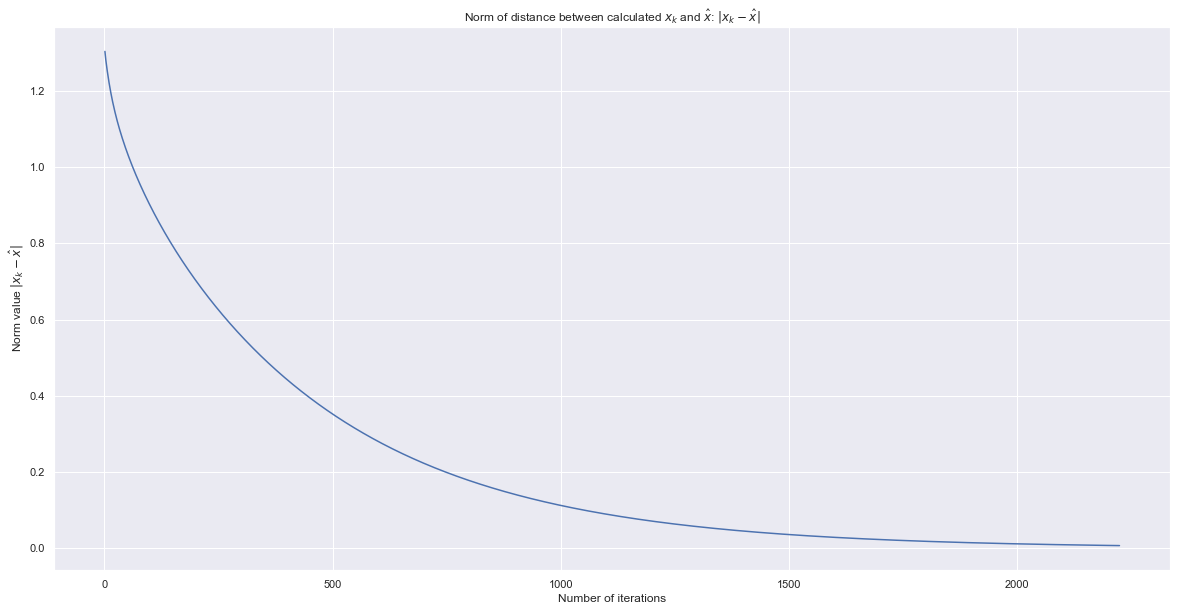

Solution found in 2224 iteratons
Solution found using pseudoinverse 
 [[ 0.23137 -0.38996  0.85896  0.45908  0.17428 -0.08715  0.59027 -0.13201
   0.12858 -0.54262]]
Solution found using Richardson iteration scheme with tolerance 0.001 
 [[ 0.22927 -0.38974  0.85575  0.45602  0.17581 -0.0851   0.58861 -0.13036
   0.12894 -0.5394 ]]


In [4]:
np.random.seed(7) #setting random seed
A = np.random.rand(20,10) #generating matrix A of size 20*10 randomly
b = np.random.rand(20,1) #generating veector b of size 20*1 randomly

x_hat = np.dot(np.linalg.pinv(A), b) #computing x_hat using pseudo-inverse of matrix A

acc = 0.001 #setting accuracy
x0 = np.zeros((10,1)) #setting x0 as zero vector

solution, errors = richardson_iter(x0, A, b, acc, x_hat) #find solution using Richardson iteration scheme

plt.figure(figsize=(20,10)) #ploting norm of distance on each step
sns.lineplot(x=np.arange(1, len(errors)+1, 1), y=np.array(errors))
plt.title('Norm of distance between calculated $x_k$ and $\hat x$: $\|x_k - \hat x \|$')
plt.ylabel("Norm value $\|x_k - \hat x \|$")
plt.xlabel("Number of iterations")
plt.show()

print("Solution found in %s iteratons" %len(errors)) #printing results
print("Solution found using pseudoinverse \n %s" %x_hat.T.round(5))
print("Solution found using Richardson iteration scheme with tolerance %s" %acc, "\n %s" %solution.T.round(5))
# print(np.linalg.norm(x_hat - solution))

As we could observe on the plot, difference between calculated $x_k$ and solution $\hat x$, found by using pseudoinverse matrix $A^+$, is going to 0 with increase of number of iterations: $\|x_k - \hat x\| \to 0$. Eventually, after 2200+ iterations, method converge to approximate solution with tolerance 0.001.

Corollary: Richardson iteration method converge to approximate solution of system $Ax=b$ with given tolerance.

# Problem 6
## Task (b) and (c)

Here I will try to fit given points using Levenberg-Marquardt algorithm. In a nutshell, follwoing steps need to be executed on each iteration:
- first of all, we need to find optimal values of angle t for given points to fit considering ellipse parameters;
- once optimal t is known, we need to calculate Jacobian matrix based on ellipse parameters, optimal t and points to fit;
- next, we calculating residual vector consisting of residual of each point;
- afterwards, we calculate descent direction using Jacobian matrix and vector of residuals;
- as last step, new value of parrameters vector theta is found by subtracting descent direction from old theta vector.

This iteration scheme repeated until required accuracy achieved. Once it achieved, results are displayed.

In [5]:
def Jacobi_row(t, x, theta): #defining function to calculate single row of Jacobian matrix based on parameters t and theta and coordinates of points X
    #below are partial derivatives per elements of vector theta - c1, c2, r, delta and alpha
    drdc1 = 2*(theta[0].item() + theta[2].item()*math.cos(theta[4].item() + t) + theta[3].item()*math.cos(theta[4].item()-t) - x[0])
    drdc2 = 2*(theta[1].item() + theta[2].item()*math.sin(theta[4].item() + t) + theta[3].item()*math.sin(theta[4].item()-t) - x[1])
    drdr = 2*(theta[0].item() + theta[2].item()*math.cos(theta[4].item() + t) + theta[3].item()*math.cos(theta[4].item()-t) - x[0])*math.cos(theta[4].item() + t) + 2*(theta[1].item() + theta[2].item()*math.sin(theta[4].item() + t) + theta[3].item()*math.sin(theta[4].item()-t) - x[1])*math.sin(theta[4].item() + t)
    drdd = 2*(theta[0].item() + theta[2].item()*math.cos(theta[4].item() + t) + theta[3].item()*math.cos(theta[4].item()-t) - x[0])*math.cos(theta[4].item() - t) + 2*(theta[1].item() + theta[2].item()*math.sin(theta[4].item() + t) + theta[3].item()*math.sin(theta[4].item()-t) - x[1])*math.sin(theta[4].item() - t)
    drda = 2*(theta[0].item() + theta[2].item()*math.cos(theta[4].item() + t) + theta[3].item()*math.cos(theta[4].item()-t) - x[0])*( - theta[2].item()*math.sin(theta[4].item() + t) - theta[3].item()*math.sin(theta[4].item()-t)) + 2*(theta[1].item() + theta[2].item()*math.sin(theta[4].item() + t) + theta[3].item()*math.sin(theta[4].item()-t) - x[1])*(theta[2].item()*math.cos(theta[4] + t) + theta[3].item()*math.cos(theta[4].item()-t))
    return np.array([drdc1, drdc2, drdr, drdd, drda])
    
def Jacobi_matrix(TX, theta): #method to calculate Jacobian matrix per set of given points X. For each point a new row is added to Jacobian matrix
    res = np.zeros(len(theta))
    for tx in TX:
        J = Jacobi_row(tx[0], (tx[1], tx[2]), theta)
        res = np.vstack((res, J))
    
    res = np.delete(res, 0, 0) #deleting initial empty row
    return res
    
def residual(t, x, theta): #calculating residual for single point based on t, coordinates of x and theta
    return(theta[0].item() + theta[2].item()*math.cos(theta[4].item()+t) + theta[3].item()*math.cos(theta[4].item()-t) - x[0])**2 + (theta[1].item() + theta[2].item()*math.sin(theta[4].item()+t) + theta[3].item()*math.sin(theta[4].item()-t) - x[1])**2

def find_t(X, theta): #method used to search for best values of t on each iteration which best allign with coordinates of points X
    res=[]
    for xi in X:
        r = minimize(lambda x: residual(x, (xi[0], xi[1]), theta), 0, method='nelder-mead') #using SciPy miniize to searc for optimal values of t
        res.append(r.x)
    return np.array(res)
    
def ellipse(T, theta): #method to calculate points of ellipse. Will be used for visualization of results
    res=[]
    for t in T:
        r = (theta[0].item() + theta[2].item()*math.cos(theta[4].item()+t[0]) + theta[3].item()*math.cos(theta[4].item()-t[0]), theta[1].item() + theta[2].item()*math.sin(theta[4].item()+t[0]) + theta[3].item()*math.sin(theta[4].item()-t[0]))
        res.append(r)
    return np.array(res)

def calc_residuals(TX, theta): #method to calculate value of residual for all points to be fit using single residual calcualtion method
    res=[]
    for tx in TX:
        r = residual(tx[0], (tx[1], tx[2]), theta) #calcualting residual for single point
        res.append(r)
    return np.array(res).reshape(len(res), 1)

Iteration number 10. Plotting interim results to show convergence.


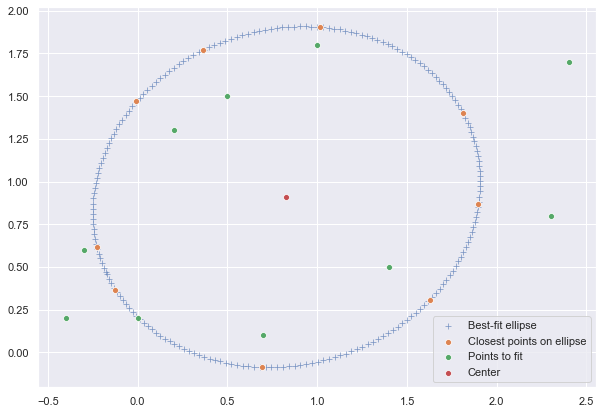

Iteration number 20. Plotting interim results to show convergence.


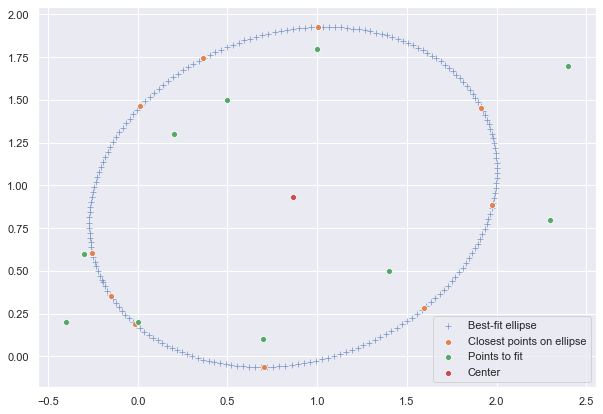

Iteration number 30. Plotting interim results to show convergence.


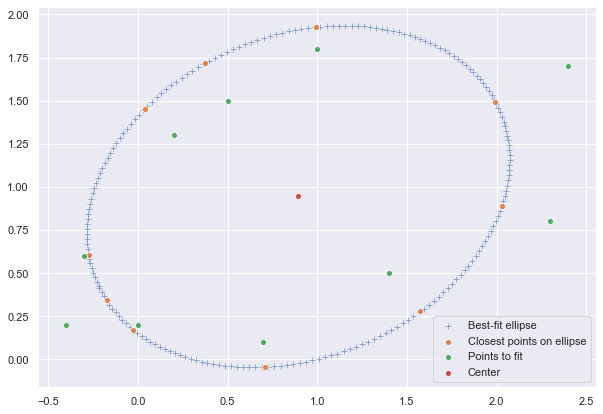

Iteration number 40. Plotting interim results to show convergence.


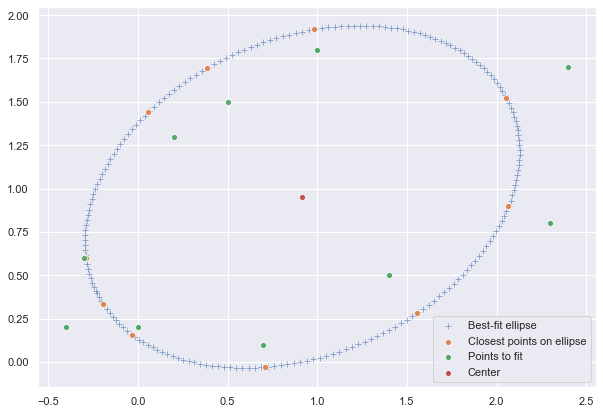

Iteration number 50. Plotting interim results to show convergence.


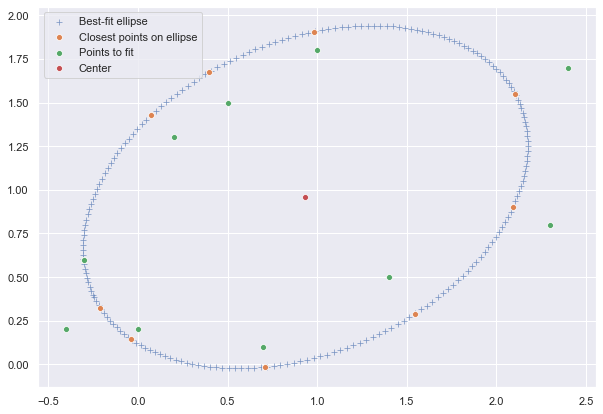

Iteration number 60. Plotting interim results to show convergence.


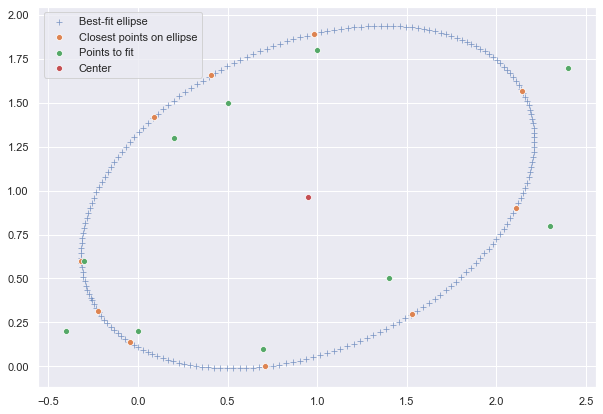

Iteration number 70. Plotting interim results to show convergence.


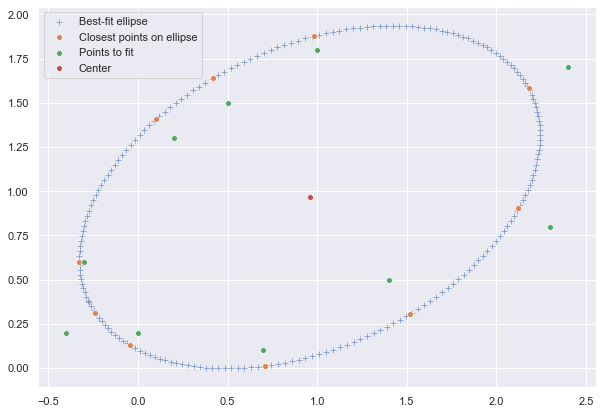

Iteration number 80. Plotting interim results to show convergence.


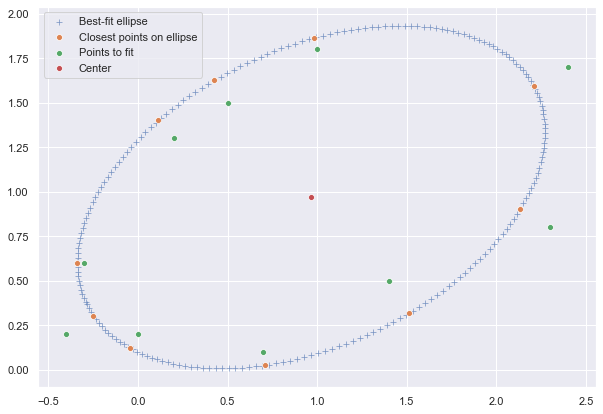

Iteration number 90. Plotting interim results to show convergence.


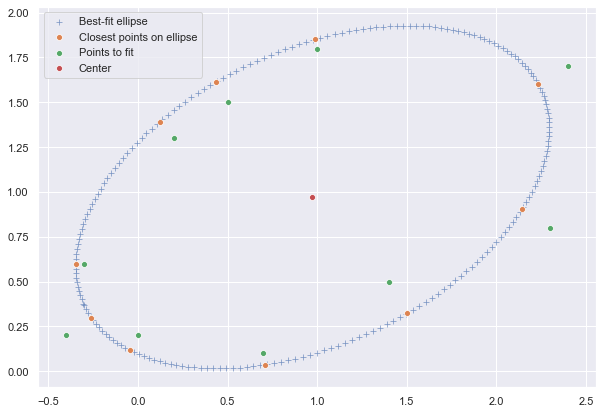

Iteration number 100. Plotting interim results to show convergence.


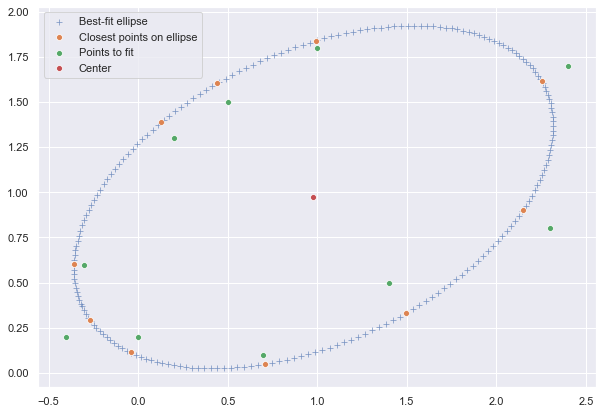

Iteration number 110. Plotting interim results to show convergence.


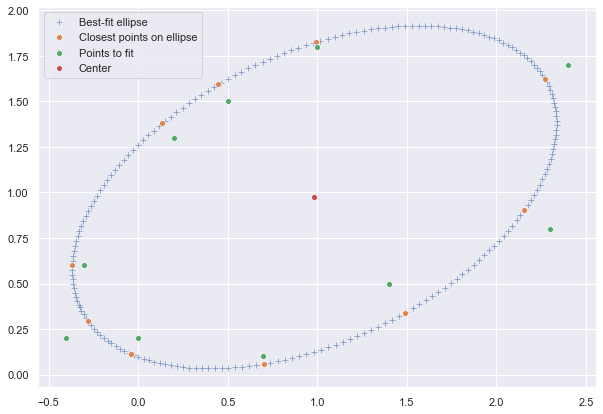

Iteration number 120. Plotting interim results to show convergence.


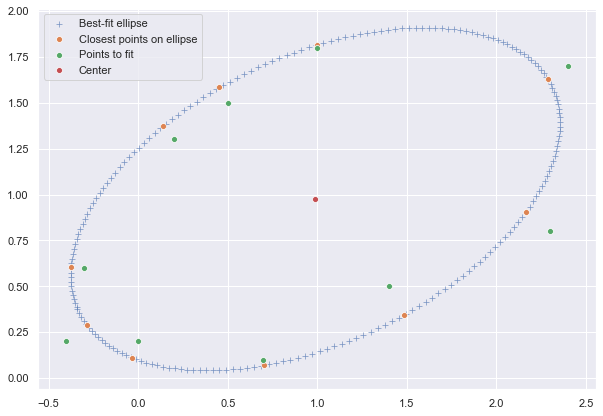

Iteration number 130. Plotting interim results to show convergence.


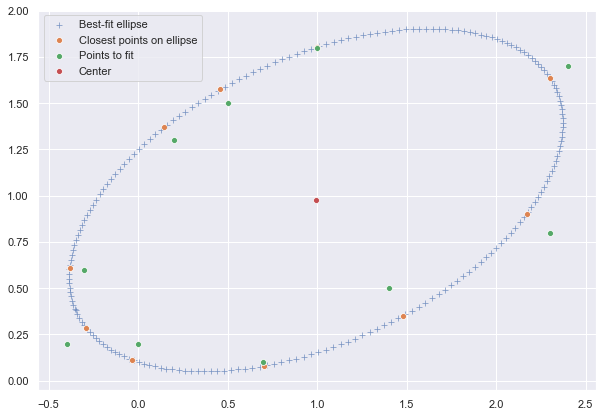

Iteration number 140. Plotting interim results to show convergence.


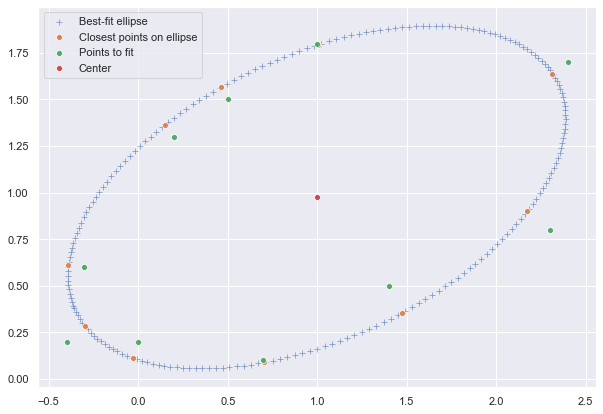

Iteration number 150. Plotting interim results to show convergence.


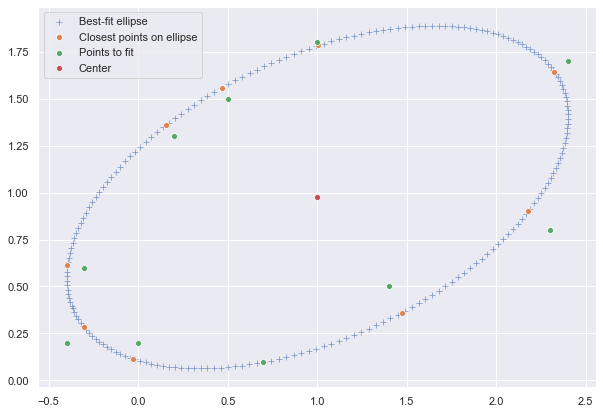

Solution found in 156 iteration(s)
Best-fit vector theta is 
 [[  1.00305]
 [  0.97641]
 [  1.12399]
 [  0.37091]
 [-78.13463]]
where:
c1 = 1.00305 
c2 = 0.97641 
r = 1.12399 
delta = 0.37091 
alpha = -78.13463
Norm of residual is 0.04076


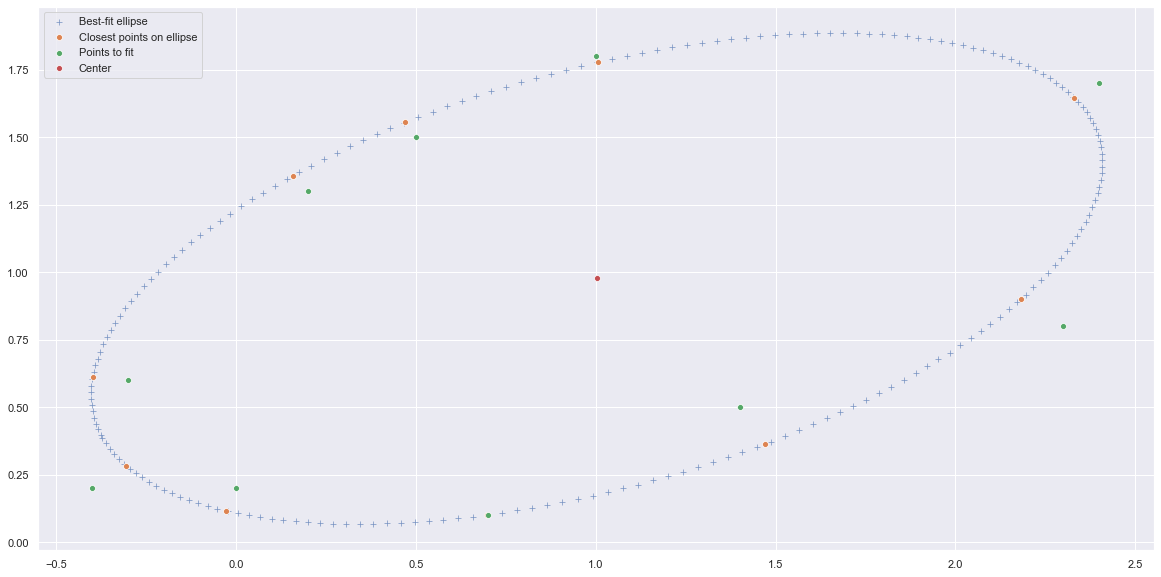

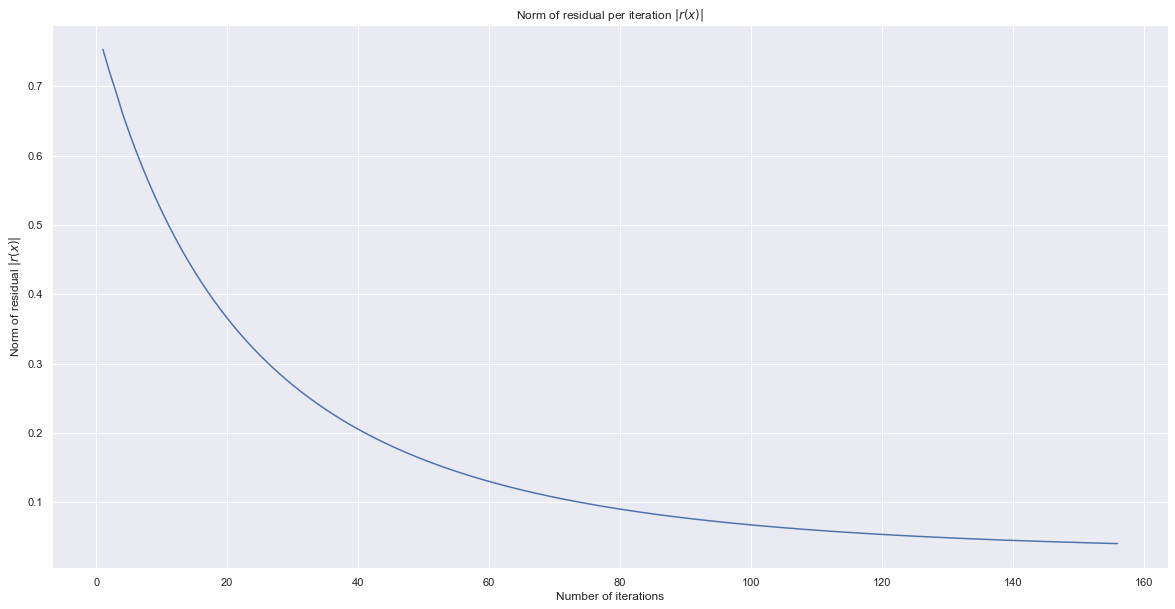

In [6]:
X = [[0.5, 1.5], #setting initial points to be fit
    [-0.3, 0.6],
    [1.0, 1.8],
    [-0.4, 0.2],
    [0.2, 1.3],
    [0.7, 0.1],
    [2.3, 0.8],
    [1.4, 0.5],
    [0.0, 0.2],
    [2.4, 1.7]]

acc = 0.001 #setting initial accuracy and value of lambda for Levenberg-Marquardt formula
lmbd = 50

X_arr = np.array(X)
theta = (X_arr[:,0].mean(), X_arr[:,1].mean(), 1, 0, 0) #defining initial value of theta, where c1 and c2 is mean value of given points accross respective axis

t_elp = np.arange(0, 2*math.pi, 0.03) #calculating values of t which will be used to visualize ellipse later
t_elp.resize(t_elp.shape[0], 1)

x_old = np.array(theta).reshape(len(theta), 1) #setting initial value of x_k as initial vector theta

residuals=[]
iter_count = 0 #initializing iteration counter
while True: #performing do-while loop until accuracy achieved
    iter_count+=1
    T_min = find_t(X_arr, x_old) #on each step looking for omtimal values of t for set of given points to fit
    TX_arr = np.hstack((T_min, X_arr))
    J = Jacobi_matrix(TX_arr, x_old) #calculating Jacobian matrix for t values found and given points
    r = calc_residuals(TX_arr, x_old) #calculating residual for t values found and given points
    residuals.append(np.linalg.norm(r)) #storing norm of residual for final plot
    p = np.dot(np.linalg.inv(np.dot(J.T, J) + lmbd*np.diag(np.dot(J.T,J).diagonal())), np.dot(J.T, r)) #calculating value of p(decent direction) using Levenberg-Marquardt formula
    x_new = x_old - p #calcualting new values of x_k+1 using descent direction found. This value will be a new vector theta on next iteration
    
    if iter_count%10 == 0: #plotting interim results once per 10 iterations (task c)
        print("Iteration number %s. Plotting interim results to show convergence." %iter_count)
        elp = ellipse(T_min, x_new) #calculating values of points for fitted points on ellipse
        line = ellipse(t_elp, x_new) #and ellipse itself using solution found
        
        plt.figure(figsize=(10,7)) #visualizing result
        sns.scatterplot(x=line[:,0], y=line[:,1], marker='+', label='Best-fit ellipse', alpha=0.7) #plotting best-fit ellipse using optimal values of theta found
        sns.scatterplot(x=elp[:,0], y=elp[:,1], label='Closest points on ellipse') #plotting closest points on ellipse for 10 given points
        sns.scatterplot(x=X_arr[:,0], y=X_arr[:,1], label='Points to fit') #plotting points to fit which were initially given
        sns.scatterplot(x=x_new[0], y=x_new[1], label='Center')
        plt.show()

    if np.linalg.norm(x_new-x_old) < acc: #check if difference between old and new values is smaller than accuracy, if smaller - solution found
        print("Solution found in %s iteration(s)" %iter_count) #if solution found print and visualize result
        print("Best-fit vector theta is \n %s" %x_new.round(5))
        print("where:\nc1 = %.5f" %x_new[0], "\nc2 = %.5f" %x_new[1], "\nr = %.5f" %x_new[2], "\ndelta = %.5f" %x_new[3], "\nalpha = %.5f" %x_new[4])
        print("Norm of residual is %.5f" %np.linalg.norm(r))
        elp = ellipse(T_min, x_new) #calculating values of points for fitted points on ellipse
        line = ellipse(t_elp, x_new) #and ellipse itself using solution found
        
        plt.figure(figsize=(20,10)) #visualizing result
        sns.scatterplot(x=line[:,0], y=line[:,1], marker='+', label='Best-fit ellipse', alpha=0.7) #plotting best-fit ellipse using optimal values of theta found
        sns.scatterplot(x=elp[:,0], y=elp[:,1], label='Closest points on ellipse') #plotting closest points on ellipse for 10 given points
        sns.scatterplot(x=X_arr[:,0], y=X_arr[:,1], label='Points to fit') #plotting points to fit which were initially given
        sns.scatterplot(x=x_new[0], y=x_new[1], label='Center')
        plt.show()
        
        plt.figure(figsize=(20,10)) #plotting norm of residual per number of iterations
        sns.lineplot(x=np.arange(1, len(residuals)+1, 1), y=np.array(residuals))
        plt.title("Norm of residual per iteration $\|r(x)\|$")
        plt.ylabel("Norm of residual $\|r(x)\|$")
        plt.xlabel("Number of iterations")
        plt.show()
        break
    
    x_old = x_new #reassing old value of x(theta) for next iteration

Interim plots (plotted on each 10th iteration) and final plot of residual vector norm shows that method converge to best possible solution within given accuracy and able to find optimal values of parameters $\theta$, which describe best-fit ellipse for set of given points.